In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
import numpy as np
from astropy.io import ascii
from astropy import units as u
from lmfit.models import PolynomialModel, GaussianModel
from lmfit import Model as mod
from lmfit import minimize, Parameters, report_fit
import scipy.integrate as integrate
import scipy.special as spec

In [3]:
# read files
OHfile_path = 'C:/Users/dhami/Research/STARTastro/DhamiBusch-Research25/OHData/159125n19875_67_ii.ascii'
COfile_path = 'C:/Users/dhami/Research/STARTastro/DhamiBusch-Research25/COData/COSpectra/159125-19875_CO.txt'
HIfile_path = 'C:/Users/dhami/Research/STARTastro/DhamiBusch-Research25/HIData/HISpectra/159.125-19.875_HI.txt'
OHdata = ascii.read(OHfile_path, data_start=3)
COdata = pd.read_csv(COfile_path, sep='\s+', header=None)
HIdata = pd.read_csv(
    HIfile_path,
    skiprows=12,
    sep='\s+',
    header=None,
    engine='python',
    on_bad_lines='skip',  # skip lines with wrong number of columns
    nrows=595
)

In [4]:
# variables
OHx=OHdata['col1']
OHy=OHdata['col2']
# Convert columns to numeric just in case
COx = pd.to_numeric(COdata[0], errors='coerce').values
COy = pd.to_numeric(COdata[1], errors='coerce').values
# Remove NaNs caused by any non-numeric values
mask = ~np.isnan(COx) & ~np.isnan(COy)
COx = COx[mask]
COy = COy[mask]
# Name the columns explicitly
HIdata.columns = ['col1', 'col2']
# Extract x and y
HIx = HIdata['col1']
HIy = HIdata['col2']

In [5]:
# OH params
#Create a model and set initial parameters
degree = 4
poly_model = PolynomialModel(degree=degree)
# Baseline regions:
OHgooddata1 = list(np.where((OHx >= -30) & (OHx <= 0))[0])
OHgooddata2 = list(np.where((OHx >= 10) & (OHx <= 30))[0])
OHgooddata = OHgooddata1 + OHgooddata2

OHparams = poly_model.guess(OHy[OHgooddata], x=OHx[OHgooddata])
OHresult = poly_model.fit(OHy[OHgooddata], OHparams, x=OHx[OHgooddata])
# generates fitted values
OHy_eval = poly_model.eval(OHresult.params, x=OHx)
y_sub = OHy - OHy_eval
#########################################################################################
gauss_model_OH=GaussianModel()
OHregion = np.where((OHx >= 0) & (OHx <= 10))[0]
# Better fit of Gaussian
def OHgaussFit(OHvel, OHta, OHbounds):
    OHx=np.asarray(OHvel) 
    y_sub=np.asarray(OHta)
    # Set bounds:
    OHregion = np.where((OHx >= OHbounds[0]) & (OHx <= OHbounds[1]))[0]
    # Initial Guess of the parameters
    OHparams = gauss_model_OH.guess(y_sub[OHregion], x=OHx[OHregion])
    # Actual best fit to the data, given initial guess
    OHregionfit= gauss_model_OH.fit(y_sub[OHregion], OHparams, x=OHx[OHregion])
    # OHfitresult = [OHregionfit]
    return OHregionfit
OHfitResult = OHgaussFit(OHx, y_sub, OHbounds = [0, 10])
OHy_gauss_region = gauss_model_OH.eval(OHfitResult.params, x=OHx)

# # plot
# plt.plot(OHx, y_sub, label='OHData', linestyle='solid', color='grey')
# plt.axhline(0, color='k')
# plt.xlim([-5, 15])
# plt.ylim([0, .5])
# plt.plot(OHx, OHy_gauss_region, '-',label='Gaussian Fit',color='red')
# plt.xlabel('Radio(km/s)')
# plt.ylabel('Ta(K)')
# plt.title('Gaussian of OHData; 158.875, -19.625')
# plt.legend()
# plt.show()

C:\Users\dhami\miniforge3\envs\STARTastro\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [6]:
'''CO Gaussian'''
gauss_model_CO=GaussianModel()
COregion = np.where((COx >= -5) & (COx <= 15))[0]
# Better fit of Gaussian
def COgaussFit(COvel, COta, CObounds):
    COx=COvel 
    COy=COta
    # Set bounds:
    COregion = np.where((COx >= CObounds[0]) & (COx <= CObounds[1]))[0]
    # Initial Guess of the parameters
    COparams = gauss_model_CO.guess(COy[COregion], x=COx[COregion])
    # Actual best fit to the data, given initial guess
    COregionfit= gauss_model_CO.fit(COy[COregion], COparams, x=COx[COregion])
    # COfitresult = [COregionfit]
    return COregionfit
COfitResult = COgaussFit(COx, COy, CObounds = [-5, 15])
COy_gauss_region = gauss_model_CO.eval(COfitResult.params, x=COx)

In [7]:
'''HI Gaussian'''
# Gaussian Fit
gauss_model_HI=GaussianModel()
HIregion = np.where((HIx >= -10) & (HIx <= 20))[0]
def HIgaussFit(HIvel, HIta, HIbounds):
    HIx = np.asarray(HIvel)
    HIy = np.asarray(HIta)
    # HIx=HIvel 
    # HIy=HIta
    # Set bounds:
    HIregion = np.where((HIx >= HIbounds[0]) & (HIx <= HIbounds[1]))[0]
    # Initial Guess of the parameters
    HIparams = gauss_model_HI.guess(HIy[HIregion], x=HIx[HIregion])
    # Actual best fit to the data, given initial guess
    HIregionfit= gauss_model_HI.fit(HIy[HIregion], HIparams, x=HIx[HIregion])
    # HIfitresult = [HIregionfit]
    return HIregionfit
HIfitResult = HIgaussFit(HIx, HIy, HIbounds = [-10, 20])
HIy_gauss_region = gauss_model_HI.eval(HIfitResult.params, x=HIx)

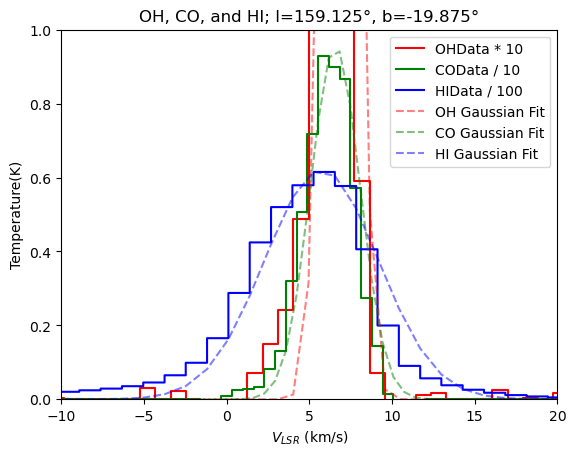

In [8]:
# plot OH, CO, and HI
plt.step(OHx, y_sub*10, label='OHData * 10', linestyle='solid', color='red')
plt.step(COx, COy/10, label='COData / 10', linestyle='solid', color='green')
plt.step(HIx, HIy/100, label='HIData / 100', linestyle='solid', color='blue')
plt.plot(OHx, OHy_gauss_region*10, '--',label='OH Gaussian Fit',color='red', alpha=0.5)
plt.plot(COx, COy_gauss_region/10, '--',label='CO Gaussian Fit',color='green', alpha=0.5)
plt.plot(HIx, HIy_gauss_region/100, '--',label='HI Gaussian Fit',color='blue', alpha=0.5)
#plt.axhline(0, color='k')
plt.xlim([-10, 20])
plt.ylim([0, 1])
plt.xlabel('$V_{LSR}$ (km/s)')
# velocity towards local standard of rest
plt.ylabel('Temperature(K)')
plt.title('OH, CO, and HI; l=159.125°, b=-19.875°')
plt.legend()
plt.show()
plt.close()